## 공매도 거래량 상위 50 종목의 위험도 분류

* 필요한 라이브러리 불러오기

In [1]:
from pykrx import stock
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings = warnings.filterwarnings('ignore')

#### 코스피 공매도 거래량 상위 50종목의 일일 위험도 산출 함수

In [2]:

def danger(day):

    #데이터 불러오기#
    trade = stock.get_market_ohlcv(day)             # 해당 날짜의 KOSPI 종목 주가데이터 
    rank = stock.get_shorting_volume_top50(day)     # 공매도 거래량 상위 50종목
    name = stock.get_market_price_change(day,day)   # 종목명 컬럼 사용을 위한 데이터
    many = pd.read_csv('./5years2.csv')             # 최근 5년동안 공매도 과열종목으로 지정된 기업 데이터

    #데이터 전처리 과정# 
    name.drop(['시가','종가','거래량','거래대금','등락률'], axis=1,inplace=True)    # 종목명 추출
    many.drop(['Unnamed: 0'],axis=1,inplace=True)

    rank_trade = pd.merge(rank,trade,on="티커", how='inner')        # rank와 trade 데이터 프레임 병합
    rank_name = pd.merge(rank_trade,name,on='티커',how='inner')     # rank_trade 데이터에 종목명 추가
    
    rank_name.drop(['총거래대금','고가','저가','거래량','거래대금','변동폭','주가수익률'],axis=1, inplace=True)         # 컬럼 정리
    rank_name =rank_name[['종목명','시가','종가','등락률','공매도거래대금','직전40일거래대금평균', 
                            '공매도거래대금증가율','공매도비중','직전40일공매도평균비중','공매도비중증가율','순위']]      # 컬럼 순서 변경

    rank_name_many = pd.merge(rank_name,many,on='종목명',how='left')       # 공매도 과열종목 지정되었었던 종목 데이터 추가
    rank_name_many.set_index(['종목명'],inplace=True)                      # 인덱스 종목코드(티커) -> 종목명으로 변경
    rank_name_many['과열횟수'] = rank_name_many['과열횟수'].fillna(0)       # 과열횟수의 결측치를 0으로 대체
    

    #위험도 계산을 위한 for문#
    rank_name_many['위험도수치'] = 0        ## 위험도수치를 계산할 컬럼 생성

    for i in range(len(rank_name_many)) :       ## 공매도거래대금증가율로 위험도 측정
            if rank_name_many['공매도거래대금증가율'][i] >= 3.0 : 
                rank_name_many['위험도수치'][i] += 5
            elif rank_name_many['공매도거래대금증가율'][i] >= 2.5 :
                rank_name_many['위험도수치'][i] += 4
            elif rank_name_many['공매도거래대금증가율'][i] >= 2.0 : 
                rank_name_many['위험도수치'][i] += 3
            elif rank_name_many['공매도거래대금증가율'][i] >= 1.5 : 
                rank_name_many['위험도수치'][i] += 2
            elif rank_name_many['공매도거래대금증가율'][i] >= 1.0 : 
                rank_name_many['위험도수치'][i] += 1

    for i in range(len(rank_name_many)) :       ## 공매도비중증가율로 위험도 측정
            if rank_name_many['공매도비중증가율'][i] >= 3.0 : 
                rank_name_many['위험도수치'][i] += 5
            elif rank_name_many['공매도비중증가율'][i] >= 2.5 :
                rank_name_many['위험도수치'][i] += 4
            elif rank_name_many['공매도비중증가율'][i] >= 2.0 : 
                rank_name_many['위험도수치'][i] += 3
            elif rank_name_many['공매도비중증가율'][i] >= 1.5 : 
                rank_name_many['위험도수치'][i] += 2
            elif rank_name_many['공매도비중증가율'][i] >= 1.0 : 
                rank_name_many['위험도수치'][i] += 1

    for i in range(len(rank_name_many)) :      ## 주가하락률로 위험도 측정
            if rank_name_many['등락률'][i] <= -10.0 :   
                rank_name_many['위험도수치'][i] += 5   
            elif rank_name_many['등락률'][i] <= -8.0 :
                rank_name_many['위험도수치'][i] += 4
            elif rank_name_many['등락률'][i] <= -6.0 : 
                rank_name_many['위험도수치'][i] += 3
            elif rank_name_many['등락률'][i] <= -4.0 : 
                rank_name_many['위험도수치'][i] += 2
            elif rank_name_many['등락률'][i] <= -2.0 : 
                rank_name_many['위험도수치'][i] += 1

    for i in range(len(rank_name_many)) :           # 5년 과열종목 지정 횟수로 위험도 측정 
            if rank_name_many['과열횟수'][i] >= 5.0 :     
                rank_name_many['위험도수치'][i] += 5
            elif rank_name_many['과열횟수'][i] >= 4.0 :
                rank_name_many['위험도수치'][i] += 4
            elif rank_name_many['과열횟수'][i] >= 3.0 : 
                rank_name_many['위험도수치'][i] += 3
            elif rank_name_many['과열횟수'][i] >= 2.0 : 
                rank_name_many['위험도수치'][i] += 2
            elif rank_name_many['과열횟수'][i] >= 1.0 : 
                rank_name_many['위험도수치'][i] += 1


    #위험도 수치를 다시 5개의 level로 분류#
    rank_name_many['위험도'] = ''  
    for i in range(len(rank_name_many)) : 
        if rank_name_many['위험도수치'][i]>= 16.0 :     
            rank_name_many['위험도'][i] ='Level5'
        elif rank_name_many['위험도수치'][i] >= 12.0 :
            rank_name_many['위험도'][i] = 'Level4'
        elif rank_name_many['위험도수치'][i] >= 8.0 : 
            rank_name_many['위험도'][i] = 'Level3'
        elif rank_name_many['위험도수치'][i] >= 4.0 : 
            rank_name_many['위험도'][i] = 'Level2'
        elif rank_name_many['위험도수치'][i] >= 0.0 : 
            rank_name_many['위험도'][i] = 'Level1'
        else:
            rank_name_many['위험도'][i] =np.NaN  
        
    return rank_name_many # 개별 종목의 위험도수치와 위험도가 포함된 데이터프레임 추출


#### 지정 날짜에 찾는 종목이 공매도거래량상위50종목에 들어가는지 확인하는 함수 #

In [3]:

def choose(data):
    a = input()
    if a not in data.index:
        return '오늘은 이 종목이 존재하지 않습니다.'
    elif a in data.index:
        return data.loc[[a]]

#### 2022년 07월 8일의 위험도 산출 예시 

형식 : danger('원하는날짜')

In [5]:
df = danger('20220708')
df.head(10)

,시가,종가,등락률,공매도거래대금,직전40일거래대금평균,공매도거래대금증가율,공매도비중,직전40일공매도평균비중,공매도비중증가율,순위,과열횟수,위험도수치,위험도
종목명,,,,,,,,,,,,,
금호석유,138500,138000,0.00,3212300500,1226170750,2.62,28.73,9.82,2.93,1,4.0,12,Level4
휠라홀딩스,28450,28500,0.71,1281448500,1025160568,1.25,28.35,11.21,2.53,2,1.0,6,Level2
엔씨소프트,378000,373500,-0.66,8377886500,5403455488,1.55,22.74,9.27,2.45,3,1.0,6,Level2
HMM,25200,25100,1.21,12901627800,11385158778,1.13,21.61,11.56,1.87,4,0.0,3,Level1
LG디스플레이,15550,15250,-1.61,7793738500,5282536679,1.48,21.59,17.93,1.20,5,2.0,4,Level2
한화솔루션,34800,34600,1.02,8279023100,4594716969,1.80,21.50,10.46,2.06,6,0.0,5,Level2
크래프톤,241000,237000,-1.46,4891879500,6797554038,0.72,20.61,10.98,1.88,7,0.0,2,Level1
LG에너지솔루션,375000,388000,3.88,30401386500,24751213500,1.23,19.94,20.41,0.98,8,0.0,1,Level1
메리츠금융지주,26650,26600,0.00,382583950,1112833556,0.34,19.75,20.67,0.96,9,1.0,1,Level1


2022년 7월 8일 공매도 거래량 상위 50종목의 위험도별 개수 시각화 

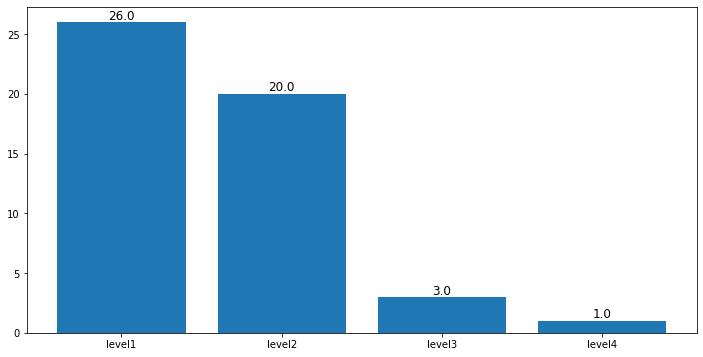

In [28]:
x = ['level1', 'level2', 'level3', 'level4']
y = pd.DataFrame(df['위험도'].value_counts())
plt.figure(figsize=(12,6))
bar = plt.bar(x,y['위험도'])
for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.1f' % height, ha='center', va='bottom', size = 12)
plt.show()

#### choose(danger함수로 출력한 데이터프레임)

위 함수를 실행하여 데이터프레임 내의 인덱스(종목명)를 입력하면 입력한 종목만 볼 수 있습니다.

In [11]:
choose(df)

,시가,종가,등락률,공매도거래대금,직전40일거래대금평균,공매도거래대금증가율,공매도비중,직전40일공매도평균비중,공매도비중증가율,순위,과열횟수,위험도수치,위험도
종목명,,,,,,,,,,,,,
금호석유,138500,138000,0.0,3212300500,1226170750,2.62,28.73,9.82,2.93,1,4.0,12,Level4


실제로 위험도가 level4로 가장 높게 측정된 금호석유가 그 다음주인 7월 11일에 주가가 전날대비 -7.97% 하락하며 과열종목으로 지정되었습니다.

이런 방식으로 자신이 투자하고 싶은 종목이 공매도 타겟 종목이 될 확률이 높은 종목인지 위 함수를 통해 확인할 수 있습니다.

## 머신러닝을 통한 공매도 주가하락 위험도 예측

* 데이터 추출 및 전처리

In [6]:
from pykrx import stock
import pandas as pd
import numpy as np

In [7]:
val_금호석유 = stock.get_shorting_value_by_date('20190102', '20220708', '011780')
bal_금호석유 = stock.get_shorting_balance_by_date('20190102', '20220708', '011780')
vol_금호석유 = stock.get_shorting_volume_by_date('20190102', '20220708', '011780')
sta_금호석유 = stock.get_shorting_status_by_date('20190102', '20220708', '011780')

In [8]:
for_금호석유 = stock.get_market_trading_value_by_date('20190102', '20220708', '011780')
for_ = for_금호석유['외국인합계']

In [9]:
stock_금호석유 = stock.get_market_ohlcv_by_date('20190102', '20220708', '011780')
stock_금호석유['Daily_rtn'] = stock_금호석유['종가'].pct_change()
stock_rtn = stock_금호석유['Daily_rtn']

In [10]:
stock_금호석유.rolling(5).sum()

,시가,고가,저가,종가,거래량,Daily_rtn
날짜,,,,,,
2019-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-03,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-04,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-07,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-08,430700.0,439600.0,419400.0,429700.0,776306.0,NaN
...,...,...,...,...,...,...
2022-07-04,709500.0,718500.0,698000.0,705500.0,358046.0,-0.030998
2022-07-05,705500.0,713500.0,694000.0,701000.0,390378.0,-0.030775
2022-07-06,702000.0,712000.0,689500.0,697500.0,429266.0,-0.024670


In [11]:
val_금호석유 # 공매도 거래대금 비중
val_금호석유['거래대금비중'] = val_금호석유['비중']
val_금 = val_금호석유[40:]
val_금 

,공매도,매수,비중,거래대금비중
날짜,,,,
2019-03-05,476706100,7199619000,6.62,6.62
2019-03-06,1401499800,11238283200,12.47,12.47
2019-03-07,432538800,8799399700,4.92,4.92
2019-03-08,674923600,9616797400,7.02,7.02
2019-03-11,1590759800,20821605500,7.64,7.64
...,...,...,...,...
2022-07-04,1779474000,9134924000,19.48,19.48
2022-07-05,1096288000,12174309500,9.00,9.00
2022-07-06,1820373500,14994788000,12.14,12.14


In [12]:
pd.options.display.float_format = '{:.5f}'.format
a = val_금호석유['공매도'].rolling(40).mean().shift(1)
val_금호석유['40일'] = a

In [13]:
val_금호 = val_금호석유[40:]
val_금호['증가배율'] = np.round(val_금호['공매도'] / val_금호['40일'], 2)

증가배율 = val_금호['증가배율']
공매도거래비중 = val_금호['비중']

In [14]:
bal_금호석유 # 공매도 잔고 비중
bal_금호석유['잔고비중'] = bal_금호석유['비중']
잔고비중 = bal_금호석유['잔고비중']

In [15]:
vol_금호석유 # 공매도 거래수량

,공매도,매수,비중
날짜,,,
2019-01-02,32445,103963,31.21000
2019-01-03,20455,111908,18.28000
2019-01-04,29283,110424,26.52000
2019-01-07,43314,349107,12.41000
2019-01-08,11089,100904,10.99000
...,...,...,...
2022-07-04,12755,65481,19.48000
2022-07-05,7799,86614,9.00000
2022-07-06,13086,107423,12.18000


In [16]:
sta_금호석유
잔고수량 = sta_금호석유['잔고수량']

In [17]:
stock_gum =stock.get_market_ohlcv_by_date('20190102','20220715','011780')
stock_gum['label'] = ( stock_gum['종가'].shift(-5) - stock_gum['종가'] ) / stock_gum['종가']
labels = stock_gum['label']
labels.tail(10)

날짜
2022-07-04   -0.09286
2022-07-05   -0.13475
2022-07-06   -0.09818
2022-07-07   -0.10507
2022-07-08   -0.14130
2022-07-11        nan
2022-07-12        nan
2022-07-13        nan
2022-07-14        nan
2022-07-15        nan
Name: label, dtype: float64

In [19]:
from functools import reduce
import pandas as pd
dfs = [for_, stock_rtn, 증가배율,공매도거래비중,잔고비중,잔고수량, labels]
df_merge = reduce(lambda left, right: pd.merge(left, right, on='날짜'), dfs)
df_merge

,외국인합계,Daily_rtn,증가배율,비중,잔고비중,잔고수량,label
날짜,,,,,,,
2019-03-05,-185315200,-0.01027,0.38000,6.62000,0.21000,63043,-0.01452
2019-03-06,-1097745300,-0.01867,1.16000,12.47000,0.22000,67043,0.01268
2019-03-07,-746340500,-0.02008,0.36000,4.92000,0.22000,66742,0.03991
2019-03-08,-2431531400,0.00971,0.59000,7.02000,0.21000,63383,0.07372
2019-03-11,-3613248000,0.01923,1.49000,7.64000,0.15000,45371,0.03774
...,...,...,...,...,...,...,...
2022-07-04,1017492500,0.00000,1.34000,19.48000,2.04000,619013,-0.09286
2022-07-05,3440545500,0.00714,0.83000,9.00000,2.03000,615880,-0.13475
2022-07-06,452326500,-0.02482,1.44000,12.14000,2.04000,617061,-0.09818


In [93]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('font', family='Malgun Gothic')

* features와 label 간의 상관관계 확인

<AxesSubplot:>

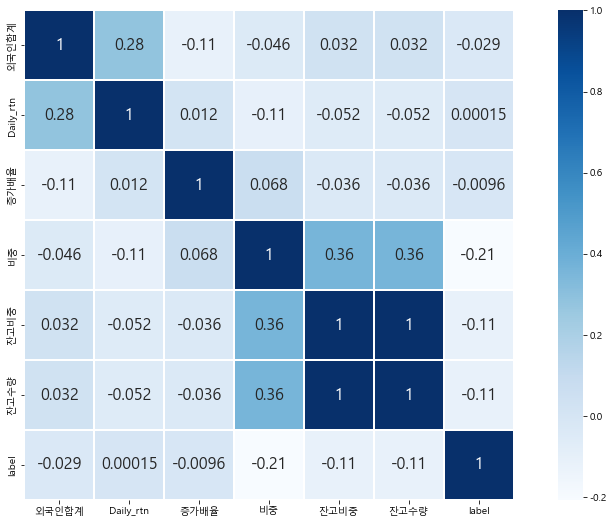

In [94]:
df_merge.corr()
plt.figure(figsize=(16,9))
sns.heatmap(df_merge.astype(float).corr(), linewidths = 0.1, vmax = 1.0,
           square = True, cmap = 'Blues', linecolor = "white", annot = True, annot_kws = {"size" : 16})

* 잔고비중과 잔고수량의 상관관계가 1로 나와, 잔고수량 feature 삭제

In [95]:
df_merge.drop(['잔고수량'], axis=1, inplace=True)
df_merge

,외국인합계,Daily_rtn,증가배율,비중,잔고비중,label
날짜,,,,,,
2019-03-05,-185315200,-0.01027,0.38000,6.62000,0.21000,-0.01452
2019-03-06,-1097745300,-0.01867,1.16000,12.47000,0.22000,0.01268
2019-03-07,-746340500,-0.02008,0.36000,4.92000,0.22000,0.03991
2019-03-08,-2431531400,0.00971,0.59000,7.02000,0.21000,0.07372
2019-03-11,-3613248000,0.01923,1.49000,7.64000,0.15000,0.03774
...,...,...,...,...,...,...
2022-07-04,1017492500,0.00000,1.34000,19.48000,2.04000,-0.09286
2022-07-05,3440545500,0.00714,0.83000,9.00000,2.03000,-0.13475
2022-07-06,452326500,-0.02482,1.44000,12.14000,2.04000,-0.09818


* label을 5일동안 수익률이 -5%일 때 1, 나머지를 0으로 설정

In [ ]:
for i in range(len(df_merge)):

    if df_merge['label'][i] <= -0.04:
        df_merge['label'][i] = 1
    else :
        df_merge['label'][i] = 0

* label을 features가 있는 데이터프레임과 분리

In [97]:
df_data = df_merge.drop(['label'],axis=1)
df_target = df_merge['label']

In [98]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

In [99]:
df_data

,외국인합계,Daily_rtn,증가배율,비중,잔고비중
날짜,,,,,
2019-03-05,-185315200,-0.01027,0.38000,6.62000,0.21000
2019-03-06,-1097745300,-0.01867,1.16000,12.47000,0.22000
2019-03-07,-746340500,-0.02008,0.36000,4.92000,0.22000
2019-03-08,-2431531400,0.00971,0.59000,7.02000,0.21000
2019-03-11,-3613248000,0.01923,1.49000,7.64000,0.15000
...,...,...,...,...,...
2022-07-04,1017492500,0.00000,1.34000,19.48000,2.04000
2022-07-05,3440545500,0.00714,0.83000,9.00000,2.03000
2022-07-06,452326500,-0.02482,1.44000,12.14000,2.04000


* '외국인합계'와 '잔고수량'의 값이 커서 MinMaxScaler를 통해 전처리

In [100]:
from sklearn.preprocessing import MinMaxScaler
min = MinMaxScaler()
min_scaled = min.fit_transform(df_data)
minmax_fit = pd.DataFrame(min_scaled, columns=['외국인합계', 'Daily_rtn', '증가배율', '비중', '잔고비중'])
minmax_fit

,외국인합계,Daily_rtn,증가배율,비중,잔고비중
0,0.36035,0.28979,0.00159,0.18456,0.03480
1,0.35574,0.27050,0.00486,0.34764,0.03663
2,0.35752,0.26726,0.00151,0.13716,0.03663
3,0.34901,0.33563,0.00247,0.19571,0.03480
4,0.34304,0.35749,0.00624,0.21299,0.02381
...,...,...,...,...,...
824,0.36642,0.31335,0.00561,0.54307,0.36996
825,0.37866,0.32975,0.00348,0.25091,0.36813
826,0.36357,0.25639,0.00603,0.33844,0.36996
827,0.37492,0.32170,0.00172,0.14023,0.36447


In [101]:
X_train, X_test, y_train, y_test = train_test_split(minmax_fit, df_target, test_size=0.2, random_state=56)

In [102]:
gb_clf = GradientBoostingClassifier(random_state=56)
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

print('GBM 정확도 : {0:.4f}'.format(gb_accuracy))

GBM 정확도 : 0.7169


In [103]:
params = {'n_estimators' : [100, 150, 200], 'learning_rate' : [0.05, 0.1]}
num_folds = 10
kfold = KFold(n_splits=num_folds, random_state=56, shuffle=True)
grid_cv = GridSearchCV(gb_clf , param_grid=params, verbose=1, cv = kfold)

grid_result = grid_cv.fit(X_train, y_train)
print('최고예측 정확도:', grid_result.best_score_, '최적 하이퍼 파라미터 :', grid_result.best_params_)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
최고예측 정확도: 0.7675938489371326 최적 하이퍼 파라미터 : {'learning_rate': 0.05, 'n_estimators': 100}


* XGBClassifier 모델로도 예측을 해보았으나 예측력이 좋지 않아 GBM 모델로 선정하였습니다.

In [105]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import KFold

In [106]:
param_grid = {'n_estimators' : [100,180], 'max_depth' : [3,5], 'min_child_weight':[1,3], 'colsample_bytree':[0.5, 0.75]}
model = XGBClassifier()
num_folds = 5
scoring = 'roc_auc'
kfold = KFold(n_splits=num_folds, random_state=56, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv = kfold)
grid_result = grid.fit(X_train, y_train)
print('최고예측 정확도:', grid_result.best_score_, '최적 하이퍼 파라미터 :', grid_result.best_params_)

최고예측 정확도: 0.6149226598304013 최적 하이퍼 파라미터 : {'colsample_bytree': 0.75, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 180}


##### 위 두가지 지표를 통해 공매도의 영향을 받는 종목의 단기 주가 하락률을 예측하여 개인 투자자들의 공매도로 인한 손실을 방지할 수 있습니다. 앞으로 두 지표의 예측력을 더 높이는 방향으로 연구를 지속할 예정입니다. 